In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 1. YOLOv5 깃허브 코드 클론
!git clone https://github.com/ultralytics/yolov5.git
%cd yolov5

# 2. 필요한 라이브러리 설치
!pip install -r requirements.txt


Cloning into 'yolov5'...
remote: Enumerating objects: 17582, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 17582 (delta 0), reused 0 (delta 0), pack-reused 17579 (from 2)
Receiving objects: 100% (17582/17582), 16.86 MiB | 30.66 MiB/s, done.
Resolving deltas: 100% (11973/11973), done.
/content/yolov5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 23.2 MB/s eta 0:00:00


In [ ]:
import cv2, os, random
import numpy as np
from datetime import datetime

# ==== 경로 설정 ====
background_dir = "/content/drive/MyDrive/final_project/baseline/camera11_yolo_dataset/images/train"
label_dir = "/content/drive/MyDrive/final_project/baseline/camera11_yolo_dataset/labels/train"
crop_img_dir = "/content/drive/MyDrive/final_project/250930_02_crop/images"
crop_lbl_dir = "/content/drive/MyDrive/final_project/250930_02_crop/labels"  # crop 라벨 경로 추가

# ==== 현재 시간 기반 폴더명 생성 ====
now = datetime.now().strftime("%y-%m-%d_%H%M")
save_root = f"/content/drive/MyDrive/final_project/copypaste_multi_{now}"

save_img_dir = os.path.join(save_root, "images")
save_lbl_dir = os.path.join(save_root, "labels")
os.makedirs(save_img_dir, exist_ok=True)
os.makedirs(save_lbl_dir, exist_ok=True)

print(f"✅ 결과 저장 경로: {save_root}")


# ==== IoU 계산 함수 ====
def iou(boxA, boxB):
    xA, yA = max(boxA[0], boxB[0]), max(boxA[1], boxB[1])
    xB, yB = min(boxA[2], boxB[2]), min(boxA[3], boxB[3])
    inter = max(0, xB - xA) * max(0, yB - yA)
    areaA = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    areaB = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    union = areaA + areaB - inter
    return inter / union if union > 0 else 0


# ==== crop 붙이기 함수 ====
def copy_paste_multi(bg_img, bg_label_path, crop_list, max_paste=3):
    h, w = bg_img.shape[:2]
    new_labels = []

    # 기존 라벨 읽기
    if os.path.exists(bg_label_path):
        with open(bg_label_path, "r") as f:
            for line in f.readlines():
                cls, x, y, bw, bh = map(float, line.strip().split())
                cx, cy = x * w, y * h
                bw, bh = bw * w, bh * h
                x1, y1, x2, y2 = int(cx - bw/2), int(cy - bh/2), int(cx + bw/2), int(cy + bh/2)
                new_labels.append([int(cls), x1, y1, x2, y2])

    # 랜덤 개수 선택 (1~3개)
    n_paste = random.randint(1, max_paste)

    for _ in range(n_paste):
        crop_path, lbl_path = random.choice(crop_list)
        crop = cv2.imread(crop_path)
        if crop is None or not os.path.exists(lbl_path):
            continue

        ch, cw = crop.shape[:2]

        # crop 라벨 읽어서 cls_id 가져오기 (하나만 있다고 가정)
        with open(lbl_path, "r") as f:
            line = f.readline().strip().split()
            if len(line) < 5:
                continue
            cls_id = int(line[0])  # crop 이미지의 class id

        # === 천장 영역에 배치 (상단 20%) ===
        x1 = random.randint(0, w - cw)
        y1 = random.randint(0, int(h*0.2) - ch)
        x2, y2 = x1 + cw, y1 + ch

        # IoU 체크 (겹치지 않게)
        overlap = False
        for _, bx1, by1, bx2, by2 in new_labels:
            if iou([x1,y1,x2,y2], [bx1,by1,bx2,by2]) > 0.3:
                overlap = True
                break

        if not overlap:
            # crop 붙이기
            bg_img[y1:y2, x1:x2] = crop
            # 라벨 저장
            new_labels.append([cls_id, x1, y1, x2, y2])

    return bg_img, new_labels


# ==== 실행 ====
crop_list = []
for fname in os.listdir(crop_img_dir):
    if fname.endswith(".jpg"):
        img_path = os.path.join(crop_img_dir, fname)
        lbl_path = os.path.join(crop_lbl_dir, fname.replace(".jpg", ".txt"))
        crop_list.append((img_path, lbl_path))

for fname in os.listdir(background_dir):
    if not fname.endswith(".jpg"):
        continue
    img_path = os.path.join(background_dir, fname)
    lbl_path = os.path.join(label_dir, fname.replace(".jpg", ".txt"))

    bg_img = cv2.imread(img_path)
    if bg_img is None:
        continue

    new_img, new_labels = copy_paste_multi(bg_img, lbl_path, crop_list, max_paste=3)

    # 결과 이미지 저장
    cv2.imwrite(os.path.join(save_img_dir, fname), new_img)

    # 결과 라벨 저장 (YOLO 형식)
    with open(os.path.join(save_lbl_dir, fname.replace(".jpg", ".txt")), "w") as f:
        for cls, x1, y1, x2, y2 in new_labels:
            cx = (x1 + x2) / 2 / bg_img.shape[1]
            cy = (y1 + y2) / 2 / bg_img.shape[0]
            bw = (x2 - x1) / bg_img.shape[1]
            bh = (y2 - y1) / bg_img.shape[0]
            f.write(f"{cls} {cx:.6f} {cy:.6f} {bw:.6f} {bh:.6f}\n")


✅ 결과 저장 경로: /content/drive/MyDrive/final_project/copypaste_multi_25-10-02_0443


총 라벨 파일 개수: 481
클래스별 객체 수: {0: 1447, 1: 1818, 2: 1433}


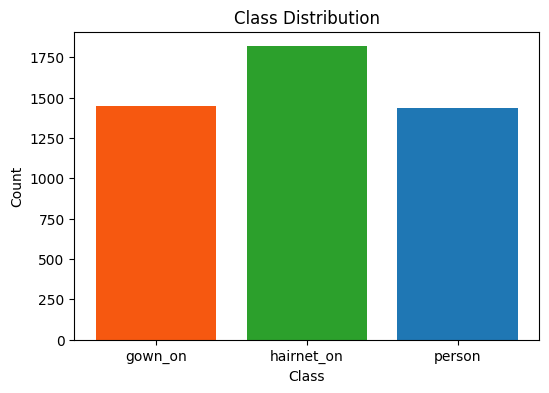

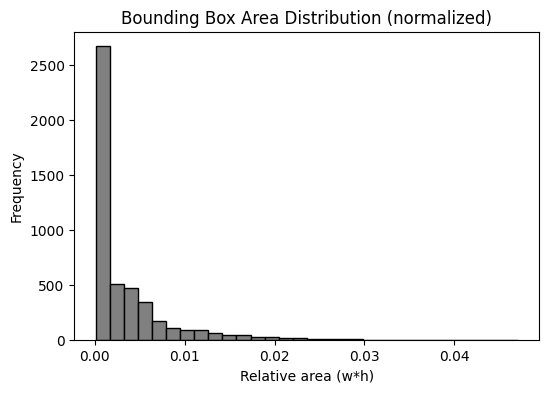

소형: 4632, 중형: 66, 대형: 0


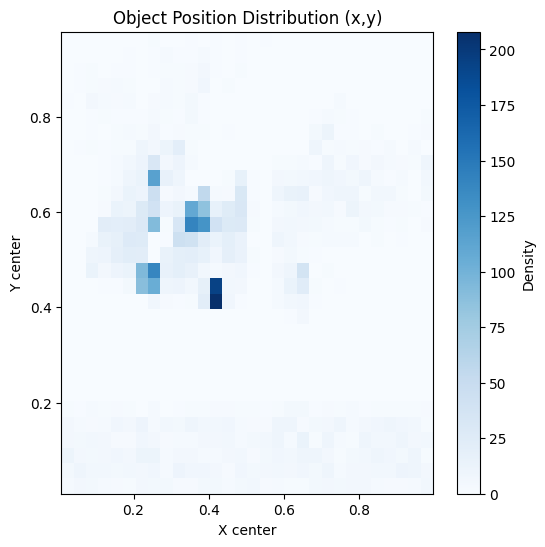

In [ ]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt

# ==== 데이터셋 경로 (labels 폴더) ====
label_dir = "/content/drive/MyDrive/final_project/copypaste_multi_25-10-02_0443/labels"

# ==== 클래스 이름 (사용자 정의) ====
class_names = ["gown_on", "hairnet_on", "person"]

# ==== 통계 저장 ====
class_counts = {i: 0 for i in range(len(class_names))}
box_areas = []
positions = []

# ==== 라벨 읽기 ====
label_files = glob.glob(os.path.join(label_dir, "*.txt"))

for lbl_path in label_files:
    with open(lbl_path, "r") as f:
        for line in f.readlines():
            cls, x, y, w, h = map(float, line.strip().split())
            cls = int(cls)
            class_counts[cls] += 1
            area = w * h
            box_areas.append(area)
            positions.append((x, y, cls))

print(f"총 라벨 파일 개수: {len(label_files)}")
print("클래스별 객체 수:", class_counts)

# ==== 1. 클래스 분포 ====
plt.figure(figsize=(6,4))
plt.bar(class_names, [class_counts[i] for i in range(len(class_names))], color=["#f65810","#2ca02c","#1f77b4"])
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

# ==== 2. 객체 크기 분포 ====
plt.figure(figsize=(6,4))
plt.hist(box_areas, bins=30, color="gray", edgecolor="black")
plt.title("Bounding Box Area Distribution (normalized)")
plt.xlabel("Relative area (w*h)")
plt.ylabel("Frequency")
plt.show()

# 소형/중형/대형 비율 계산
small = sum(1 for a in box_areas if a < 0.02)   # 2% 이하
medium = sum(1 for a in box_areas if 0.02 <= a < 0.05)
large = sum(1 for a in box_areas if a >= 0.05)
print(f"소형: {small}, 중형: {medium}, 대형: {large}")

# ==== 3. 위치 분포 (히트맵) ====
xs = [p[0] for p in positions]
ys = [p[1] for p in positions]

plt.figure(figsize=(6,6))
plt.hist2d(xs, ys, bins=30, cmap="Blues")
plt.colorbar(label="Density")
plt.title("Object Position Distribution (x,y)")
plt.xlabel("X center")
plt.ylabel("Y center")
plt.show()


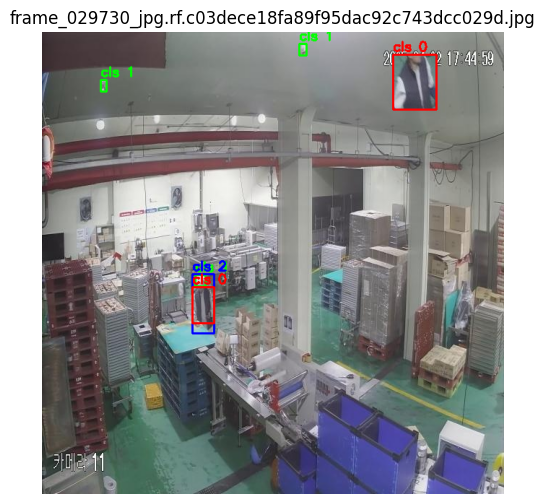

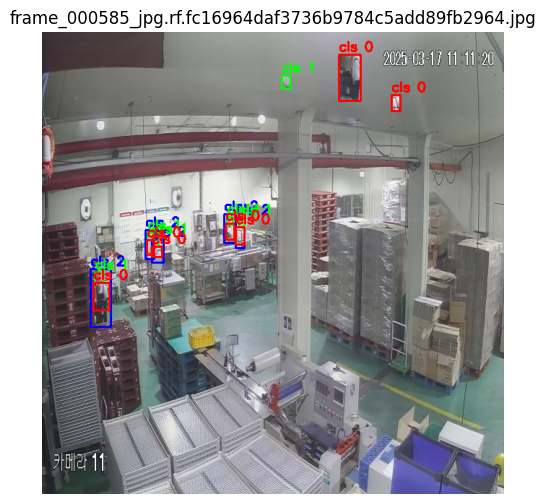

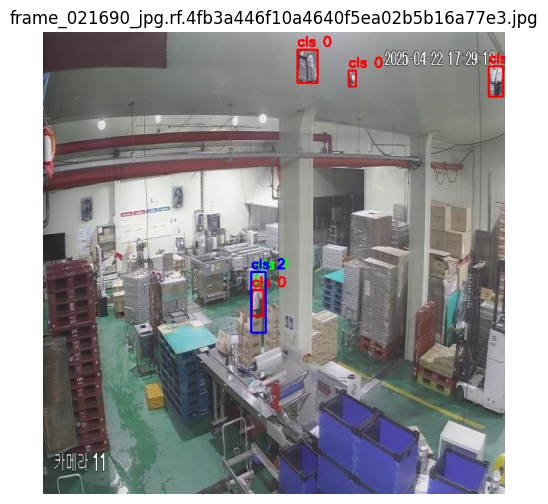

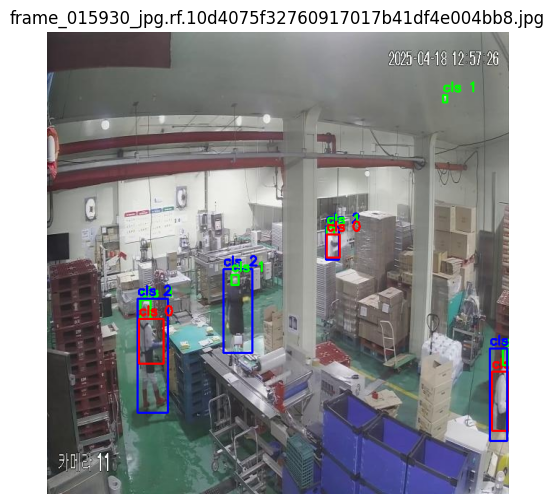

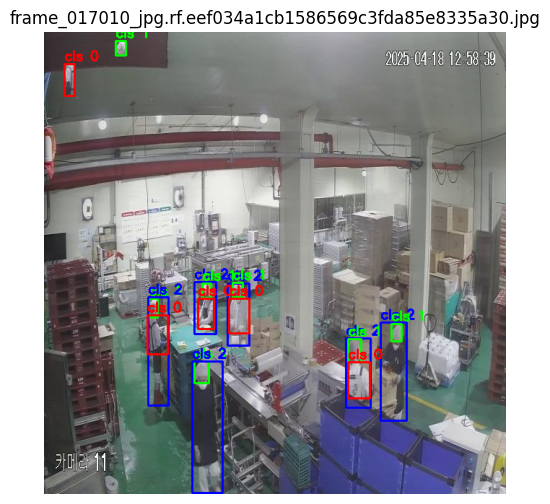

In [ ]:
import matplotlib.pyplot as plt
import random

# ==== 저장된 결과 폴더 ====
result_img_dir = save_img_dir
result_lbl_dir = save_lbl_dir

# ==== 랜덤 5장 선택 ====
files = [f for f in os.listdir(result_img_dir) if f.endswith(".jpg")]
sample_files = random.sample(files, min(5, len(files)))

# ==== 시각화 ====
for fname in sample_files:
    img_path = os.path.join(result_img_dir, fname)
    lbl_path = os.path.join(result_lbl_dir, fname.replace(".jpg", ".txt"))

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # 라벨 박스 그리기
    if os.path.exists(lbl_path):
        with open(lbl_path, "r") as f:
            for line in f.readlines():
                cls, x, y, bw, bh = map(float, line.strip().split())
                h, w = img.shape[:2]
                cx, cy = int(x * w), int(y * h)
                bw, bh = int(bw * w), int(bh * h)
                x1, y1 = cx - bw//2, cy - bh//2
                x2, y2 = cx + bw//2, cy + bh//2
                color = (255,0,0) if cls==0 else (0,255,0) if cls==1 else (0,0,255)
                cv2.rectangle(img, (x1,y1), (x2,y2), color, 2)
                cv2.putText(img, f"cls {int(cls)}", (x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

    plt.figure(figsize=(6,6))
    plt.imshow(img)
    plt.axis("off")
    plt.title(fname)
    plt.show()


In [ ]:
import matplotlib.pyplot as plt
import cv2
import os
import random

# ==== 저장된 결과 폴더 (직접 경로 지정) ====
result_img_dir = "/content/drive/MyDrive/final_project/copypaste_multi_25-10-02_0443/images"
result_lbl_dir = "/content/drive/MyDrive/final_project/copypaste_multi_25-10-02_0443/labels"

# ==== 랜덤 20장 선택 ====
files = [f for f in os.listdir(result_img_dir) if f.endswith(".jpg")]
sample_files = random.sample(files, min(20, len(files)))

# ==== 그리드 출력 (4x5) ====
fig, axes = plt.subplots(4, 5, figsize=(20, 16))
axes = axes.flatten()

for ax, fname in zip(axes, sample_files):
    img_path = os.path.join(result_img_dir, fname)
    lbl_path = os.path.join(result_lbl_dir, fname.replace(".jpg", ".txt"))

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # 라벨 박스 그리기
    if os.path.exists(lbl_path):
        with open(lbl_path, "r") as f:
            for line in f.readlines():
                cls, x, y, bw, bh = map(float, line.strip().split())
                h, w = img.shape[:2]
                cx, cy = int(x * w), int(y * h)
                bw, bh = int(bw * w), int(bh * h)
                x1, y1 = cx - bw//2, cy - bh//2
                x2, y2 = cx + bw//2, cy + bh//2
                color = (255,0,0) if cls==0 else (0,255,0) if cls==1 else (0,0,255)
                cv2.rectangle(img, (x1,y1), (x2,y2), color, 2)
                cv2.putText(img, f"cls {int(cls)}", (x1, y1-5),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

    ax.imshow(img)
    ax.axis("off")
    ax.set_title(fname, fontsize=8)

plt.tight_layout()
plt.show()


In [ ]:
from datetime import datetime

# ==== 경로 설정 ====
train_dir = "/content/drive/MyDrive/final_project/copypaste_multi_25-10-02_0443/images"
val_dir   = "/content/drive/MyDrive/final_project/baseline/camera11_yolo_dataset/images/valid"
test_dir  = "/content/drive/MyDrive/final_project/baseline/camera11_yolo_dataset/images/test"

# ==== 현재 시간 기반 파일명/폴더명 ====
now = datetime.now().strftime("%y-%m-%d_%H%M")

# ==== data.yaml 생성 ====
data_yaml = f"""
train: {train_dir}
val: {val_dir}
test: {test_dir}

nc: 3
names: ['gown_on', 'hairnet_on', 'person']
"""

yaml_path = f"/content/drive/MyDrive/final_project/data_copypaste_{now}.yaml"
with open(yaml_path, "w") as f:
    f.write(data_yaml)

print("✅ YAML 파일 생성 완료:", yaml_path)


# ===============================
# === 학습 실행 부분 ============
# ===============================

# 학습 설정 변수
img_size = 640
batch_size = 16
epochs = 100
model = "yolov5n"
condition = "copypaste_multi"

# 자동 experiment name 생성
exp_name = f"{now}_{condition}_{model}_img{img_size}_ep{epochs}"

# === 학습 실행 ===
!python train.py \
  --img {img_size} \
  --batch {batch_size} \
  --epochs {epochs} \
  --data {yaml_path} \
  --weights {model}.pt \
  --project /content/drive/MyDrive/final_project/runs/ \
  --name {exp_name} \
  --exist-ok


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  with torch.cuda.amp.autocast(amp):
      25/99      2.41G    0.05336    0.03276    0.01445        154        640:  61% 19/31 [00:01<00:01, 11.31it/s]/content/yolov5/yolov5/train.py:414: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
      25/99      2.41G    0.05346    0.03264    0.01435        196        640:  61% 19/31 [00:01<00:01, 11.31it/s]/content/yolov5/yolov5/train.py:414: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
      25/99      2.41G    0.05355    0.03273    0.01434        210        640:  68% 21/31 [00:01<00:00, 11.01it/s]/content/yolov5/yolov5/train.py:414: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(

In [ ]:
from datetime import datetime

# ==== 경로 설정 ====
train_dir = "/content/drive/MyDrive/final_project/copypaste_multi_25-10-02_0443/images"
val_dir   = "/content/drive/MyDrive/final_project/baseline/camera11_yolo_dataset/images/valid"
test_dir  = "/content/drive/MyDrive/final_project/baseline/camera11_yolo_dataset/images/test"

# ==== 현재 시간 기반 파일명/폴더명 ====
now = datetime.now().strftime("%y-%m-%d_%H%M")

# ==== data.yaml 생성 ====
data_yaml = f"""
train: {train_dir}
val: {val_dir}
test: {test_dir}

nc: 3
names: ['gown_on', 'hairnet_on', 'person']
"""

yaml_path = f"/content/drive/MyDrive/final_project/data_copypaste_{now}.yaml"
with open(yaml_path, "w") as f:
    f.write(data_yaml)

print("✅ YAML 파일 생성 완료:", yaml_path)


# ===============================
# === 학습 실행 부분 ============
# ===============================

# 학습 설정 변수
img_size = 640
batch_size = 16
epochs = 50
model = "yolov5n"
condition = "copypaste_multi"

# 자동 experiment name 생성
exp_name = f"{now}_{condition}_{model}_img{img_size}_ep{epochs}"

# === 학습 실행 ===
!python train.py \
  --img {img_size} \
  --batch {batch_size} \
  --epochs {epochs} \
  --data {yaml_path} \
  --weights {model}.pt \
  --project /content/drive/MyDrive/final_project/runs/ \
  --name {exp_name} \
  --exist-ok


✅ YAML 파일 생성 완료: /content/drive/MyDrive/final_project/data_copypaste_25-10-02_0649.yaml
wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2025-10-02 06:49:59.817183: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759387799.838933   35177 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759387799.845500   35177 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1759387799.862327   35177 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1

In [ ]:
import os

root_dir = "/content/drive/MyDrive/final_project/runs"

# runs 폴더 내 모든 하위 폴더 확인
folders = [f for f in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, f))]

print("📂 runs 폴더 내 하위 폴더 목록:")
for f in folders:
    print("-", f)


📂 runs 폴더 내 하위 폴더 목록:
- 251001_01_copypaste_yolov5n
- 251001_02_baseline_yolov5n
- 251001_03_blend_yolov5n
- 251002_01_copypaste_blend_yolov5n
- 251002_02_copypaste_hardpaste_yolov5n
- 251003_ceiling_positive_yolov5n
- 251003_ceiling_negative_yolov5n
- 251002_ceiling_positive_yolov5n_ep100
- 251002_ceiling_positive_yolov5n_960_ep100
- 251001_02_baseline_yolov5n_960
- 251001_02_baseline_yolov5n_640_ep100
- 25-10-02_0604_baseline_yolov5n_img640_ep50
- 25-10-02_0636_copypaste_multi_yolov5n_img640_ep100
- 25-10-02_0649_copypaste_multi_yolov5n_img640_ep50


In [ ]:
import pandas as pd
import os
from glob import glob

# ==== 비교 대상 폴더 ====
exp_dirs = {
    "baseline": "/content/drive/MyDrive/final_project/runs/25-10-02_0604_baseline_yolov5n_img640_ep50",
    "copypaste": "/content/drive/MyDrive/final_project/runs/251001_01_copypaste_yolov5n",
    "blend": "/content/drive/MyDrive/final_project/runs/251002_01_copypaste_blend_yolov5n",
    "hardpaste": "/content/drive/MyDrive/final_project/runs/251002_02_copypaste_hardpaste_yolov5n",
    "ceiling_pos": "/content/drive/MyDrive/final_project/runs/251003_ceiling_positive_yolov5n",
    "ceiling_neg": "/content/drive/MyDrive/final_project/runs/251003_ceiling_negative_yolov5n",
    "multi_cp": "/content/drive/MyDrive/final_project/runs/25-10-02_0649_copypaste_multi_yolov5n_img640_ep50"
}

# ==== results.csv 불러오기 ====
def load_results_csv(run_dir):
    csv_path = glob(os.path.join(run_dir, "**/results.csv"), recursive=True)
    if not csv_path:
        print(f"⚠️ results.csv not found in {run_dir}")
        return None
    df = pd.read_csv(csv_path[0])
    df.columns = [c.strip() for c in df.columns]  # 공백 제거
    return df.iloc[-1][[
        "metrics/precision","metrics/recall","metrics/mAP_0.5","metrics/mAP_0.5:0.95"
    ]]

# ==== 결과 수집 ====
records = []
for name, path in exp_dirs.items():
    res = load_results_csv(path)
    if res is not None:
        records.append({
            "Experiment": name,
            "Precision": res["metrics/precision"],
            "Recall": res["metrics/recall"],
            "mAP@0.5": res["metrics/mAP_0.5"],
            "mAP@0.5:0.95": res["metrics/mAP_0.5:0.95"],
        })

df_compare = pd.DataFrame(records).round(3)
print("✅ YOLOv5n Ep50 성능 비교 결과\n")
display(df_compare)


⚠️ results.csv not found in /content/drive/MyDrive/final_project/runs/251002_02_copypaste_hardpaste_yolov5n
✅ YOLOv5n Ep50 성능 비교 결과



Experiment  Precision  Recall  mAP@0.5  mAP@0.5:0.95
0     baseline      0.816   0.811    0.871         0.432
1    copypaste      0.791   0.780    0.835         0.404
2        blend      0.804   0.799    0.842         0.398
3  ceiling_pos      0.813   0.821    0.874         0.426
4  ceiling_neg      0.824   0.822    0.875         0.426
5     multi_cp      0.844   0.779    0.857         0.421

In [ ]:
import pandas as pd

# 예시: baseline 폴더의 results.csv 열 이름 확인
df = pd.read_csv("/content/drive/MyDrive/final_project/runs/25-10-02_0604_baseline_yolov5n_img640_ep50/results.csv")
print(df.columns.tolist())


['               epoch', '      train/box_loss', '      train/obj_loss', '      train/cls_loss', '   metrics/precision', '      metrics/recall', '     metrics/mAP_0.5', 'metrics/mAP_0.5:0.95', '        val/box_loss', '        val/obj_loss', '        val/cls_loss', '               x/lr0', '               x/lr1', '               x/lr2']


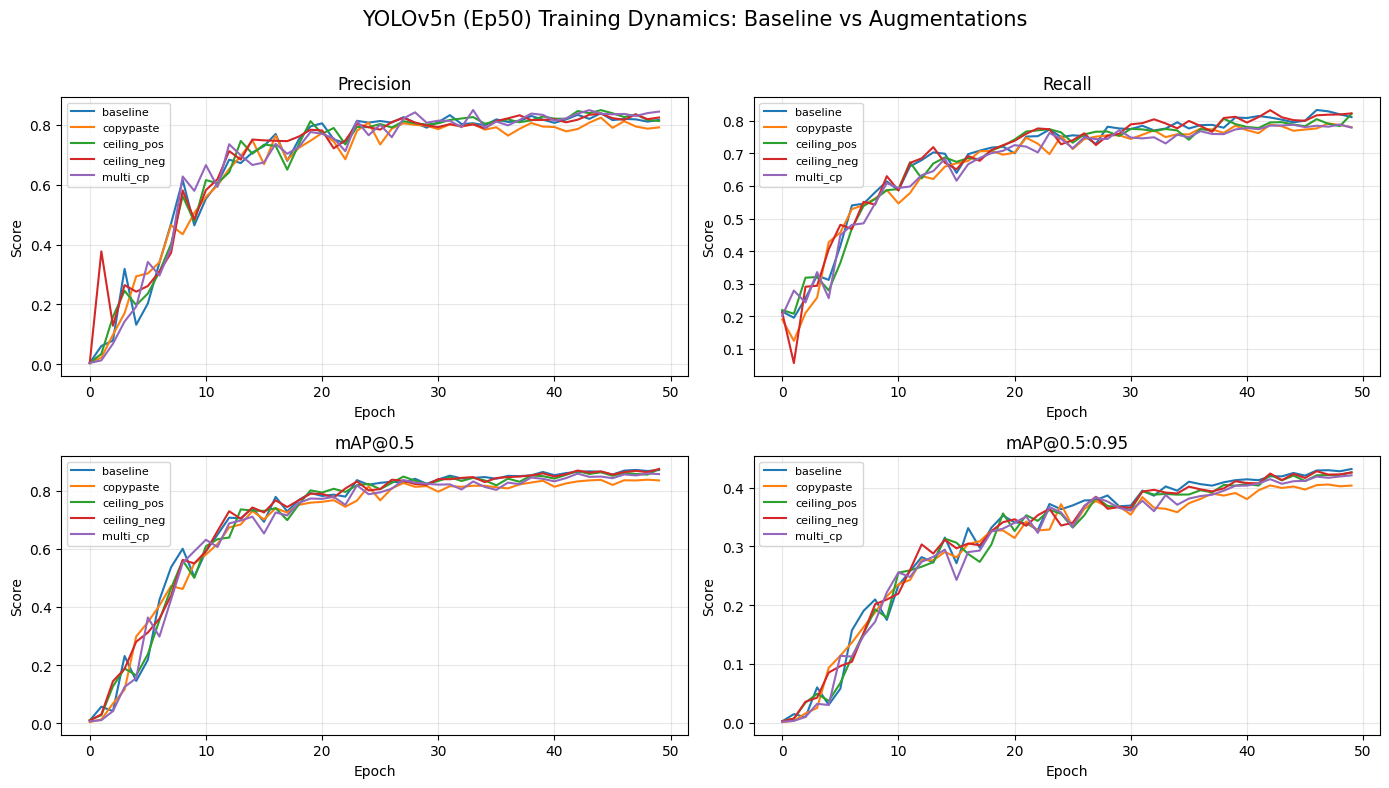

✅ Final Epoch Comparison:


metrics/precision  metrics/recall  metrics/mAP_0.5  \
baseline                 0.816           0.811            0.871   
copypaste                0.791           0.780            0.835   
ceiling_pos              0.813           0.821            0.874   
ceiling_neg              0.824           0.822            0.875   
multi_cp                 0.844           0.779            0.857   

             metrics/mAP_0.5:0.95  
baseline                    0.432  
copypaste                   0.404  
ceiling_pos                 0.426  
ceiling_neg                 0.426  
multi_cp                    0.421

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from glob import glob

# ==== 실험 폴더 ====
exp_dirs = {
    "baseline": "/content/drive/MyDrive/final_project/runs/25-10-02_0604_baseline_yolov5n_img640_ep50",
    "copypaste": "/content/drive/MyDrive/final_project/runs/251001_01_copypaste_yolov5n",

    "ceiling_pos": "/content/drive/MyDrive/final_project/runs/251003_ceiling_positive_yolov5n",
    "ceiling_neg": "/content/drive/MyDrive/final_project/runs/251003_ceiling_negative_yolov5n",
    "multi_cp": "/content/drive/MyDrive/final_project/runs/25-10-02_0649_copypaste_multi_yolov5n_img640_ep50"
}

# ==== results.csv 불러오기 함수 ====
def load_results(run_dir):
    csv_path = glob(os.path.join(run_dir, "**/results.csv"), recursive=True)
    if not csv_path:
        print(f"⚠️ results.csv not found in {run_dir}")
        return None
    df = pd.read_csv(csv_path[0])
    df.columns = [c.strip() for c in df.columns]  # 공백 제거
    return df[["epoch", "metrics/precision", "metrics/recall", "metrics/mAP_0.5", "metrics/mAP_0.5:0.95"]]

# ==== 전체 결과 수집 ====
all_results = {}
for name, path in exp_dirs.items():
    df = load_results(path)
    if df is not None:
        all_results[name] = df

# ==== 1) 학습 곡선 플롯 ====
metrics = ["metrics/precision", "metrics/recall", "metrics/mAP_0.5", "metrics/mAP_0.5:0.95"]
titles = ["Precision", "Recall", "mAP@0.5", "mAP@0.5:0.95"]

plt.figure(figsize=(14,8))
for i, (metric, title) in enumerate(zip(metrics, titles), 1):
    plt.subplot(2,2,i)
    for name, df in all_results.items():
        plt.plot(df["epoch"], df[metric], label=name)
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.grid(alpha=0.3)
    plt.legend(fontsize=8)
plt.suptitle("YOLOv5n (Ep50) Training Dynamics: Baseline vs Augmentations", fontsize=15)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# ==== 2) 마지막 epoch 성능 요약 ====
summary = pd.DataFrame({
    name: df.iloc[-1][["metrics/precision","metrics/recall","metrics/mAP_0.5","metrics/mAP_0.5:0.95"]]
    for name, df in all_results.items()
}).T.round(3)

print("✅ Final Epoch Comparison:")
display(summary)


In [ ]:
%cd /content/yolov5  # YOLOv5 설치 경로로 이동
from IPython.display import Image, display
import os


[Errno 2] No such file or directory: '/content/yolov5 # YOLOv5 설치 경로로 이동'
/content/yolov5


In [ ]:
val_dir  = "/content/drive/MyDrive/final_project/baseline/camera11_yolo_dataset/images/valid"
test_dir = "/content/drive/MyDrive/final_project/baseline/camera11_yolo_dataset/images/test"

# 결과 저장 폴더
save_root = "/content/drive/MyDrive/final_project/detect_results"
!mkdir -p {save_root}


In [ ]:
weights = {
    "baseline": "/content/drive/MyDrive/final_project/runs/25-10-02_0604_baseline_yolov5n_img640_ep50/weights/best.pt",
    "copypaste": "/content/drive/MyDrive/final_project/runs/251001_01_copypaste_yolov5n/weights/best.pt",
    "ceiling_pos": "/content/drive/MyDrive/final_project/runs/251003_ceiling_positive_yolov5n/weights/best.pt",
    "ceiling_neg": "/content/drive/MyDrive/final_project/runs/251003_ceiling_negative_yolov5n/weights/best.pt",
    "multi_cp": "/content/drive/MyDrive/final_project/runs/25-10-02_0649_copypaste_multi_yolov5n_img640_ep50/weights/best.pt"
}


In [ ]:
%cd /content/yolov5

for name, w in weights.items():
    print(f"🔍 Detecting with {name} ...")
    !python detect.py \
      --weights {w} \
      --source {test_dir} \
      --img 640 --conf 0.25 --save-txt --save-conf \
      --project {save_root} --name {name} --exist-ok


%cd /content/yolov5

for name, w in weights.items():
    print(f"🔍 Detecting with {name} ...")
    !python detect.py \
      --weights {w} \
      --source {test_dir} \
      --img 640 --conf 0.25 --save-txt --save-conf \
      --project {save_root} --name {name} --exist-ok


/content/yolov5
🔍 Detecting with baseline ...
detect: weights=['/content/drive/MyDrive/final_project/runs/25-10-02_0604_baseline_yolov5n_img640_ep50/weights/best.pt'], source=/content/drive/MyDrive/final_project/baseline/camera11_yolo_dataset/images/test, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_format=0, save_csv=False, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=/content/drive/MyDrive/final_project/detect_results, name=baseline, exist_ok=True, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-432-g725b922e Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (NVIDIA A100-SXM4-80GB, 81222MiB)

Fusing layers... 
Model summary: 157 layers, 1763224 parameters, 0 gradients, 4.1 GFLOPs
image 1/69 /content/drive/MyDrive/final_project/baseline/camera11_yolo_dataset/image

In [ ]:
!python val.py \
  --weights /content/drive/MyDrive/final_project/runs/251003_ceiling_positive_yolov5n/weights/best.pt \
  --data /content/drive/MyDrive/final_project/data.yaml \
  --task test --conf 0.25 --save-json --save-conf --project {save_root} --name ceiling_pos_val


val: data=/content/drive/MyDrive/final_project/data.yaml, weights=['/content/drive/MyDrive/final_project/runs/251003_ceiling_positive_yolov5n/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.25, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=True, save_json=True, project=/content/drive/MyDrive/final_project/detect_results, name=ceiling_pos_val, exist_ok=False, half=False, dnn=False
WARNING ⚠️ confidence threshold 0.25 > 0.001 produces invalid results
YOLOv5 🚀 v7.0-432-g725b922e Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (NVIDIA A100-SXM4-80GB, 81222MiB)

Fusing layers... 
Model summary: 157 layers, 1763224 parameters, 0 gradients, 4.1 GFLOPs
100% 755k/755k [00:00<00:00, 121MB/s]
test: Scanning /content/drive/MyDrive/final_project/baseline/camera11_yolo_dataset/labels/test... 69 images, 0 backgrounds, 0 corrupt: 100% 69/69 [00:06<00:00, 10.02it/s]
test: New cache created: /cont

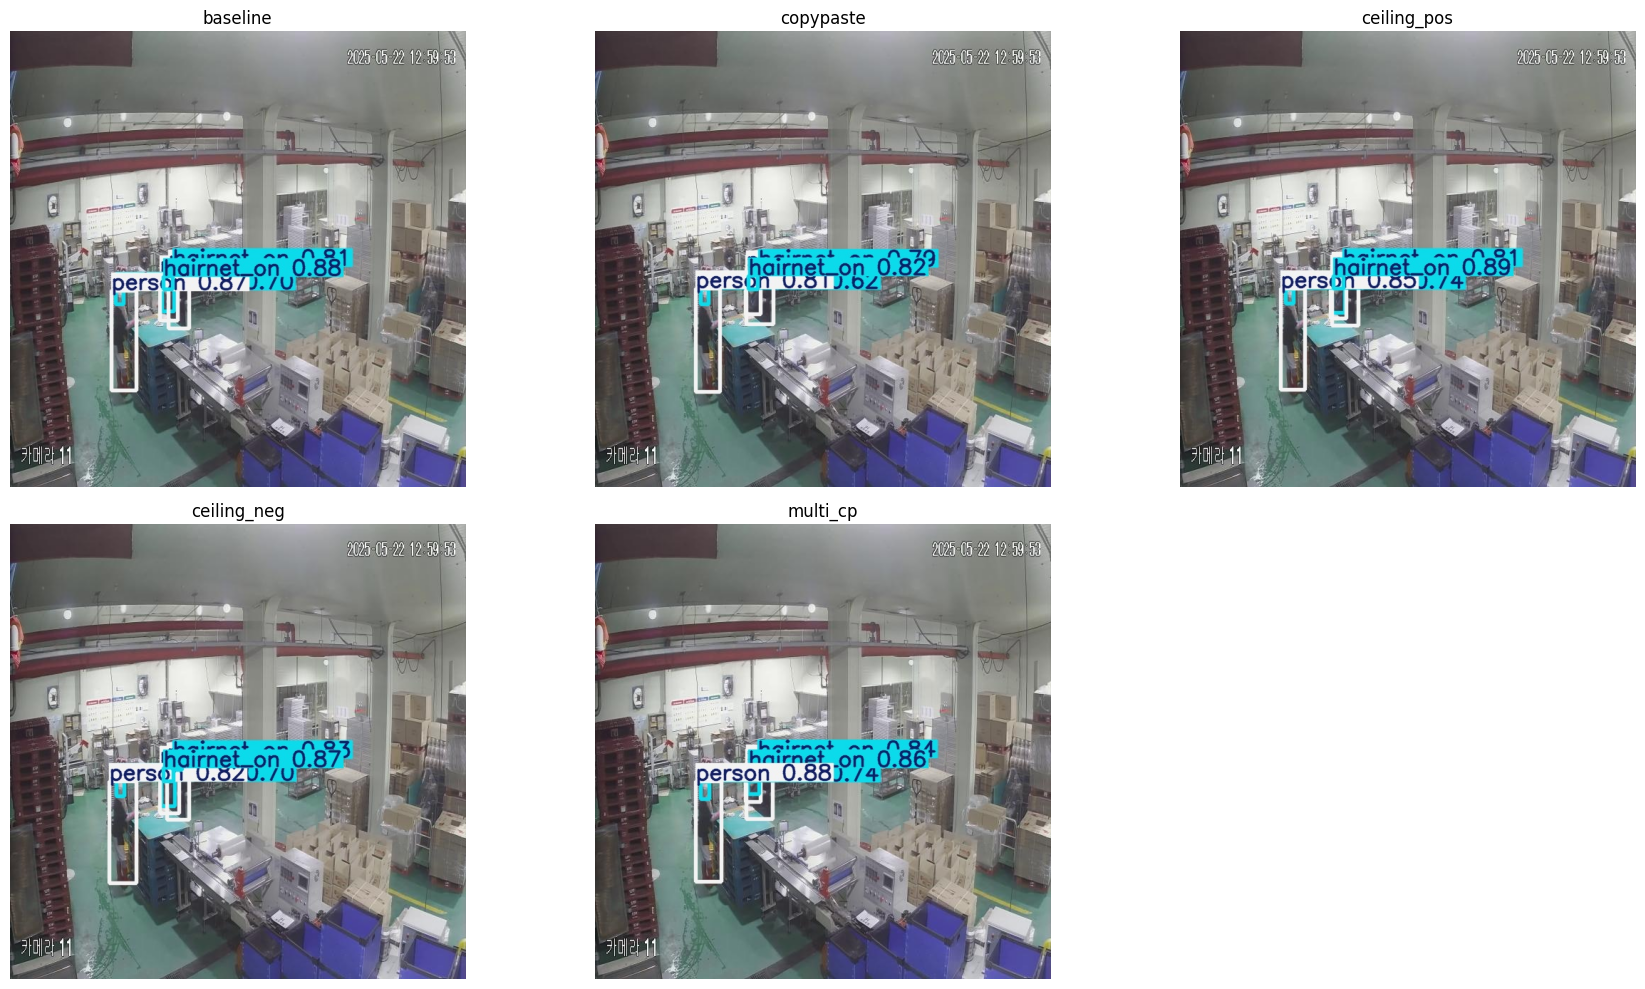

In [ ]:
import matplotlib.pyplot as plt
import cv2, glob, os

plt.figure(figsize=(18,10))

for i, name in enumerate(weights.keys()):
    img_files = glob.glob(f"{save_root}/{name}/*.jpg")  # detect 결과 이미지 가져오기
    if len(img_files) > 0:
        img = cv2.imread(img_files[0])  # 첫 번째 이미지
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(2,3,i+1)
        plt.imshow(img)
        plt.title(name)
        plt.axis("off")
    else:
        print(f"⚠️ {name} 폴더에 결과 이미지가 없음")

plt.tight_layout()
plt.show()


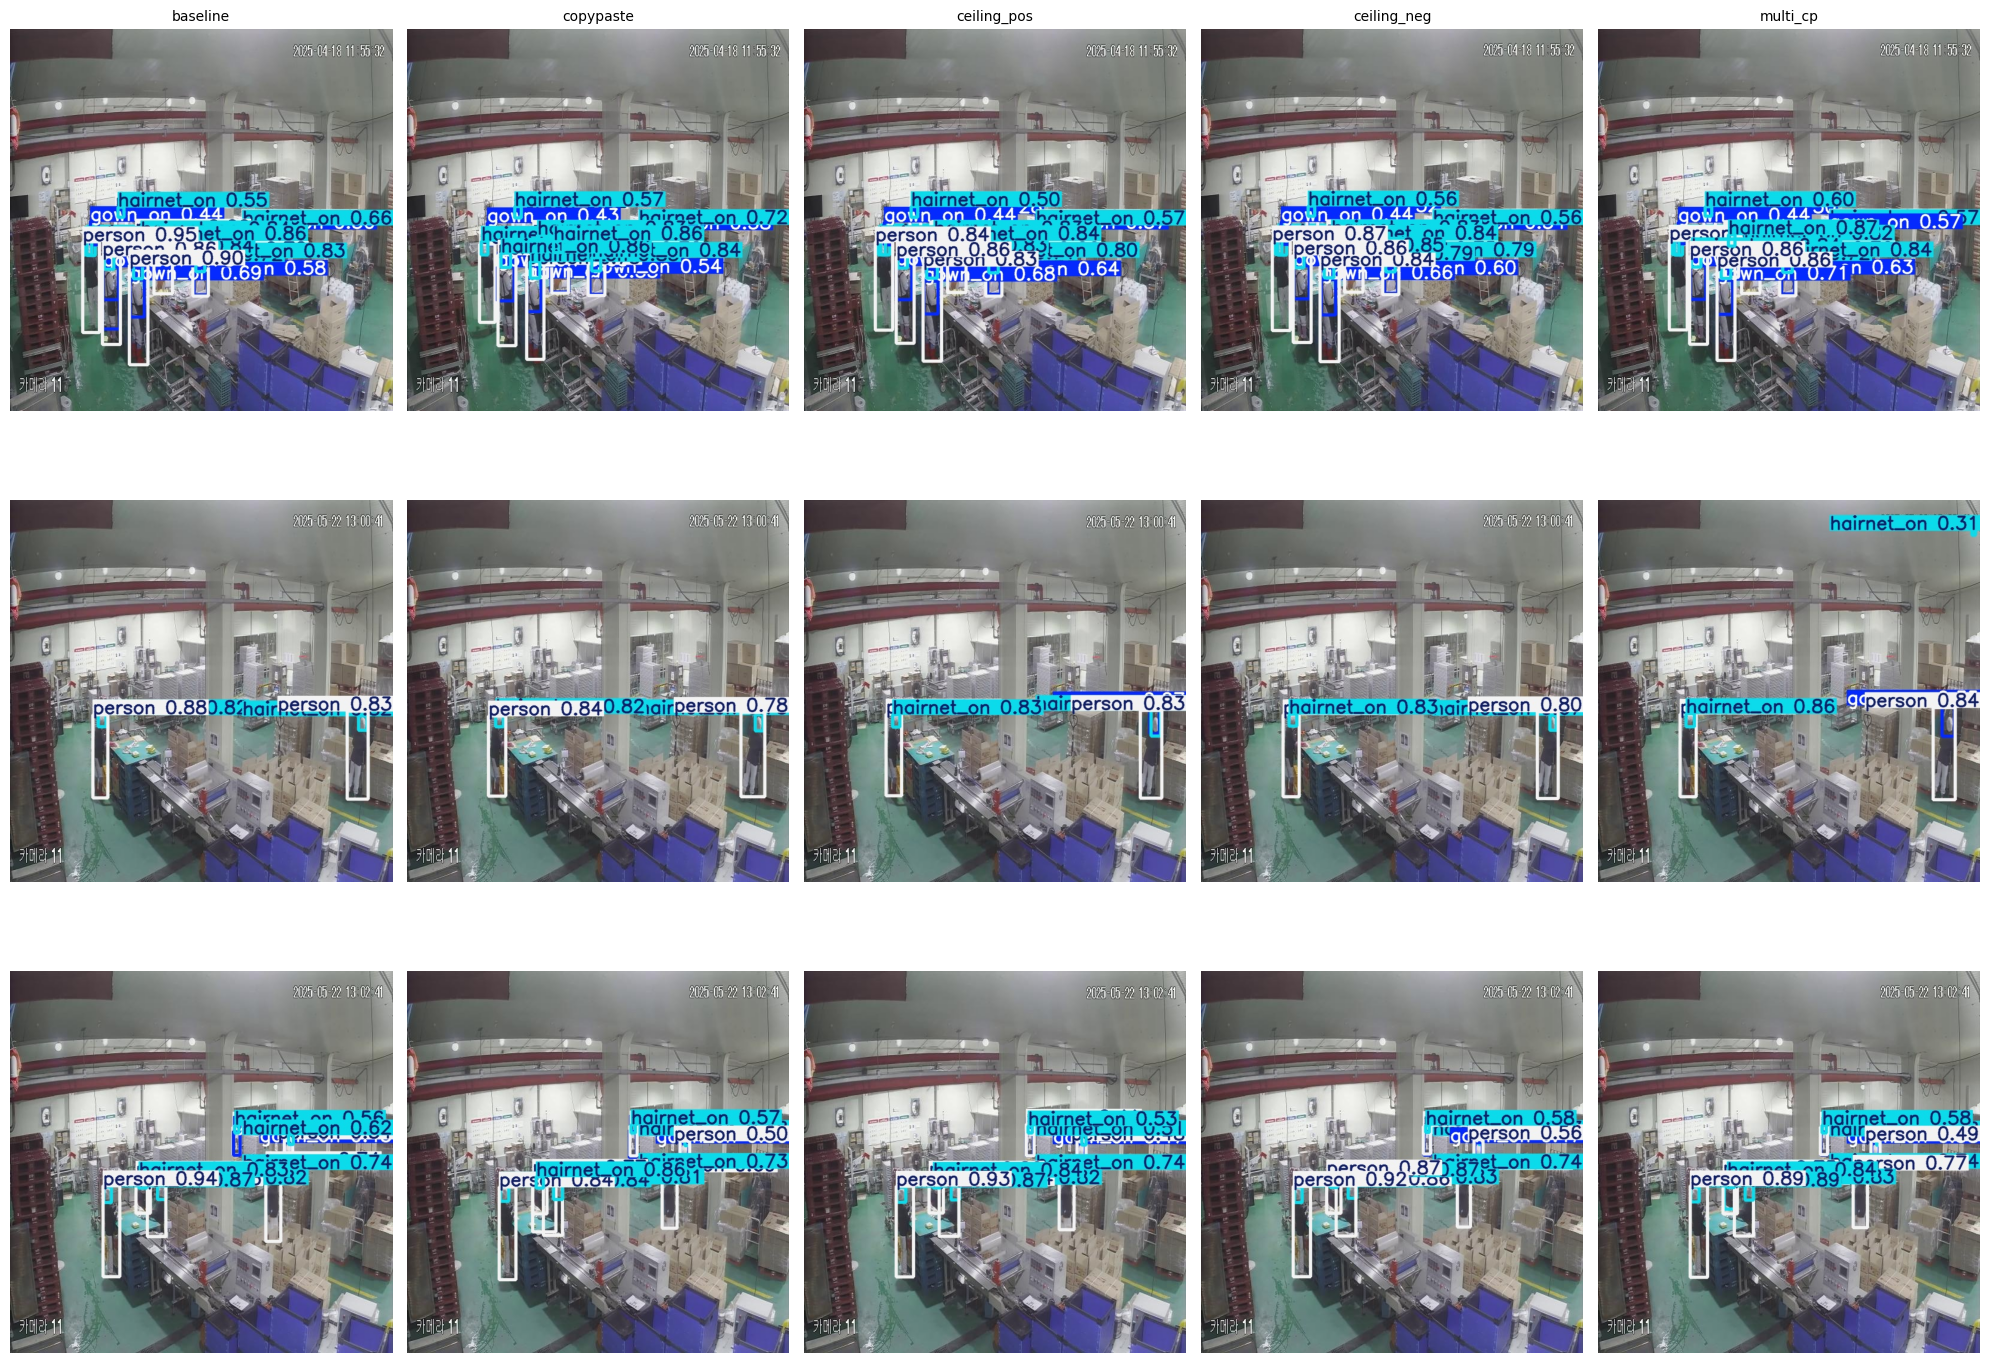

In [ ]:
import matplotlib.pyplot as plt
import cv2, glob, os

# 테스트셋에서 이미지 파일 목록 불러오기
test_images = glob.glob(os.path.join(test_dir, "*.jpg"))
test_images = sorted(test_images)[4:7]  # 앞에서 3장만 (원하면 숫자 늘리세요)

plt.figure(figsize=(20, 15))

plot_idx = 1
for img_name in test_images:
    base_filename = os.path.basename(img_name)

    for model_idx, name in enumerate(weights.keys()):
        # detect 결과 이미지 경로
        detect_img_path = f"{save_root}/{name}/{base_filename}"
        if os.path.exists(detect_img_path):
            img = cv2.imread(detect_img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.subplot(len(test_images), len(weights), plot_idx)
            plt.imshow(img)
            if plot_idx <= len(weights):  # 첫 줄은 제목 표시
                plt.title(name, fontsize=10)
            if model_idx == 0:  # 첫 번째 열에는 원본 파일명 표시
                plt.ylabel(base_filename, fontsize=10)
            plt.axis("off")
        else:
            print(f"⚠️ {detect_img_path} 없음")
        plot_idx += 1

plt.tight_layout()
plt.show()


In [ ]:
%%writefile /content/yolov5/detect_custom.py
import argparse
import os
import sys
from pathlib import Path
import torch
from models.common import DetectMultiBackend
from utils.datasets import LoadImages, LoadStreams
from utils.general import (LOGGER, check_file, check_img_size, check_imshow, increment_path,
                           non_max_suppression, print_args, scale_boxes, strip_optimizer, xyxy2xywh)
from utils.plots import Annotator, colors
from utils.torch_utils import select_device, time_sync

@torch.no_grad()
def run(weights='yolov5s.pt',  # model path or triton URL
        source='data/images',  # file/dir/URL/glob/screen/0(webcam)
        imgsz=(640, 640),  # inference size (height, width)
        conf_thres=0.25,  # confidence threshold
        iou_thres=0.45,  # NMS IOU threshold
        max_det=1000,  # maximum detections per image
        device='',  # cuda device, i.e. 0 or 0,1,2,3 or cpu
        view_img=False,  # show results
        save_txt=False,  # save results to *.txt
        save_conf=False,  # save confidences in --save-txt labels
        save_crop=False,  # save cropped prediction boxes
        nosave=False,  # do not save images/videos
        classes=None,  # filter by class
        agnostic_nms=False,  # class-agnostic NMS
        augment=False,  # augmented inference
        visualize=False,  # visualize features
        update=False,  # update all models
        project='runs/detect',  # save results to project/name
        name='exp',  # save results to project/name
        exist_ok=False,  # existing project/name ok, do not increment
        line_thickness=1,  # bounding box thickness (custom: thinner)
        font_size=0.4,     # font scale (custom: smaller)
        hide_labels=False,  # hide labels
        hide_conf=False,  # hide confidences
        half=False,  # use FP16 half-precision inference
        dnn=False,  # use OpenCV DNN for ONNX inference
        vid_stride=1,  # video frame-rate stride
        ):
    source = str(source)
    save_img = not nosave and not source.endswith('.txt')
    is_file = Path(source).suffix[1:] in (['jpg', 'jpeg', 'png', 'mp4', 'mov', 'avi', 'mkv'])
    is_url = source.lower().startswith(('http://', 'https://', 'rtsp://', 'rtmp://', 'tcp://'))
    webcam = source.isnumeric() or source.endswith('.txt') or (is_url and not is_file)
    if is_url and is_file:
        source = check_file(source)
    save_dir = increment_path(Path(project) / name, exist_ok=exist_ok)
    (save_dir / 'labels' if save_txt else save_dir).mkdir(parents=True, exist_ok=True)

    device = select_device(device)
    model = DetectMultiBackend(weights, device=device, dnn=dnn)
    stride, names, pt = model.stride, model.names, model.pt
    imgsz = check_img_size(imgsz, s=stride)
    dataset = LoadStreams(source, img_size=imgsz, stride=stride, auto=pt, vid_stride=vid_stride) if webcam \
        else LoadImages(source, img_size=imgsz, stride=stride, auto=pt, vid_stride=vid_stride)
    bs = len(dataset)
    model.warmup(imgsz=(1 if pt else bs, 3, *imgsz))

    dt, seen = [0.0, 0.0, 0.0], 0
    for path, im, im0s, vid_cap, s in dataset:
        t1 = time_sync()
        im = torch.from_numpy(im).to(model.device)
        im = im.half() if half else im.float()
        im /= 255
        if len(im.shape) == 3:
            im = im[None]
        t2 = time_sync()
        dt[0] += t2 - t1

        pred = model(im, augment=augment, visualize=visualize)
        t3 = time_sync()
        dt[1] += t3 - t2

        pred = non_max_suppression(pred, conf_thres, iou_thres, classes, agnostic_nms, max_det=max_det)
        dt[2] += time_sync() - t3

        for i, det in enumerate(pred):
            seen += 1
            p, im0, frame = path, im0s.copy(), getattr(dataset, 'frame', 0)
            p = Path(p)
            save_path = str(save_dir / p.name)
            txt_path = str(save_dir / 'labels' / p.stem)
            gn = torch.tensor(im0.shape)[[1, 0, 1, 0]]

            annotator = Annotator(im0, line_width=line_thickness, font_size=font_size, example=str(names))
            if len(det):
                det[:, :4] = scale_boxes(im.shape[2:], det[:, :4], im0.shape).round()
                for *xyxy, conf, cls in reversed(det):
                    c = int(cls)
                    label = None if hide_labels else (names[c] if hide_conf else f'{names[c]} {conf:.2f}')
                    annotator.box_label(xyxy, label, color=colors(c, True))

            im0 = annotator.result()
            if save_img:
                cv2.imwrite(save_path, im0)

    LOGGER.info(f"Results saved to {save_dir}")

if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument('--weights', nargs='+', type=str, default='yolov5s.pt')
    parser.add_argument('--source', type=str, default='data/images')
    parser.add_argument('--imgsz', nargs='+', type=int, default=[640, 640])
    parser.add_argument('--conf-thres', type=float, default=0.25)
    parser.add_argument('--iou-thres', type=float, default=0.45)
    parser.add_argument('--max-det', type=int, default=1000)
    parser.add_argument('--device', default='')
    parser.add_argument('--project', default='runs/detect_custom')
    parser.add_argument('--name', default='exp')
    parser.add_argument('--exist-ok', action='store_true')
    opt = parser.parse_args()
    run(**vars(opt))


Writing /content/yolov5/detect_custom.py


In [ ]:
!python val.py \
  --weights /content/drive/MyDrive/final_project/runs/251003_ceiling_positive_yolov5n/weights/best.pt \
  --data /content/drive/MyDrive/final_project/data.yaml \
  --task val \
  --img 640 --conf 0.25 \
  --project /content/drive/MyDrive/final_project/val_results \
  --name ceiling_pos_val \
  --exist-ok


val: data=/content/drive/MyDrive/final_project/data.yaml, weights=['/content/drive/MyDrive/final_project/runs/251003_ceiling_positive_yolov5n/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.25, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=/content/drive/MyDrive/final_project/val_results, name=ceiling_pos_val, exist_ok=True, half=False, dnn=False
WARNING ⚠️ confidence threshold 0.25 > 0.001 produces invalid results
YOLOv5 🚀 v7.0-433-ga1019635 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)

Fusing layers... 
Model summary: 157 layers, 1763224 parameters, 0 gradients, 4.1 GFLOPs
100% 755k/755k [00:00<00:00, 17.3MB/s]
val: Scanning /content/drive/MyDrive/final_project/baseline/camera11_yolo_dataset/labels/valid.cache... 138 images, 0 backgrounds, 0 corrupt: 100% 138/138 [00:00<?, ?it/s]
                 Class     Imag

In [ ]:
!python /content/yolov5/detect_custom.py \
  --weights /content/drive/MyDrive/final_project/runs/251003_ceiling_positive_yolov5n/weights/best.pt \
  --source {test_dir} \
  --imgsz 640 --conf-thres 0.25 \
  --project /content/drive/MyDrive/final_project/detect_results_custom \
  --name ceiling_pos --exist-ok


Traceback (most recent call last):
  File "/content/yolov5/detect_custom.py", line 7, in <module>
    from utils.datasets import LoadImages, LoadStreams
ModuleNotFoundError: No module named 'utils.datasets'


In [ ]:
import matplotlib.pyplot as plt
import cv2, glob, os
from IPython.display import display

# ===== 경로 설정 =====
test_dir = "/content/drive/MyDrive/final_project/baseline/camera11_yolo_dataset/images/test"
save_root = "/content/drive/MyDrive/final_project/detect_results_custom"

# 모델별 탐지 결과 폴더 이름 (detect 실행 시 name 값)
weights = {
    "baseline": "baseline",
    "copypaste": "copypaste",
    "blend": "blend",
    "ceiling_pos": "ceiling_pos",
    "ceiling_neg": "ceiling_neg",
    "multi_cp": "multi_cp"
}

# ===== 테스트 이미지 목록 =====
test_images = sorted(glob.glob(os.path.join(test_dir, "*.jpg")))
test_images = test_images[0:5]  # 원하는 개수만큼 조정 (예: 0:3 → 3장)

n_imgs = len(test_images)
n_models = len(weights)

# ===== Figure 생성 =====
plt.figure(figsize=(4 * n_models, 4 * n_imgs))  # 크기 자동 조정

plot_idx = 1
for img_name in test_images:
    base_filename = os.path.basename(img_name)

    for model_idx, name in enumerate(weights.keys()):
        detect_img_path = f"{save_root}/{weights[name]}/{base_filename}"

        if os.path.exists(detect_img_path):
            img = cv2.imread(detect_img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            plt.subplot(n_imgs, n_models, plot_idx)
            plt.imshow(img)
            plt.axis("off")

            # 첫 행 → 모델 이름
            if plot_idx <= n_models:
                plt.title(name, fontsize=12, pad=8, color="#333333", fontweight='bold')

            # 첫 열 → 파일 이름
            if model_idx == 0:
                plt.ylabel(base_filename, fontsize=10, rotation=0, labelpad=45, va='center')

        else:
            print(f"⚠️ {detect_img_path} 없음")
        plot_idx += 1

plt.subplots_adjust(wspace=0.02, hspace=0.05)
plt.tight_layout()
plt.show()


⚠️ /content/drive/MyDrive/final_project/detect_results_custom/baseline/frame_000000_jpg.rf.8065826564bf7fda05db331b0c5b7763.jpg 없음
⚠️ /content/drive/MyDrive/final_project/detect_results_custom/copypaste/frame_000000_jpg.rf.8065826564bf7fda05db331b0c5b7763.jpg 없음
⚠️ /content/drive/MyDrive/final_project/detect_results_custom/blend/frame_000000_jpg.rf.8065826564bf7fda05db331b0c5b7763.jpg 없음
⚠️ /content/drive/MyDrive/final_project/detect_results_custom/ceiling_pos/frame_000000_jpg.rf.8065826564bf7fda05db331b0c5b7763.jpg 없음
⚠️ /content/drive/MyDrive/final_project/detect_results_custom/ceiling_neg/frame_000000_jpg.rf.8065826564bf7fda05db331b0c5b7763.jpg 없음
⚠️ /content/drive/MyDrive/final_project/detect_results_custom/multi_cp/frame_000000_jpg.rf.8065826564bf7fda05db331b0c5b7763.jpg 없음
⚠️ /content/drive/MyDrive/final_project/detect_results_custom/baseline/frame_000120_jpg.rf.69c4cd256f1035f2a18e5d60980defbb.jpg 없음
⚠️ /content/drive/MyDrive/final_project/detect_results_custom/copypaste/frame_0

<Figure size 2400x2000 with 0 Axes>